In [1]:
# Import libraries
import os
from torch.utils.data import DataLoader,Dataset, random_split, Subset
from skimage import io, transform
from matplotlib import pyplot as plt
import numpy as np
import fnmatch
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from PIL import Image
from tqdm import tqdm


# Define the device and data repository
device = 'cpu'

In [4]:
# def transform_image(image_path,target_height, target_witdth):
#     image = Image.open(image_path)
#     transform = transforms.Resize(size = (target_height,target_witdth))
#     image = transform(image)
#     return image

def find_files(directory, pattern='*.jpeg'):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list
    
def resize_folder(dir_path,target_height,target_witdth):
    list_image_path = find_files(dir_path)
    for image_path in tqdm(list_image_path):
        #resize image
        image = Image.open(image_path)
        transform = transforms.Resize(size = (target_height,target_witdth))
        new_image = transform(image)
        
        main_dataset = image_path.split('/')[0]
        sub_dataset = image_path.split('/')[1]
        label = image_path.split('/')[2]
        file = image_path.split('/')[-1]
        file = file.split('.')[0]
        new_folder = str(main_dataset)+'/'+str(sub_dataset)+'_resized_'+str(target_height)+'_'+str(target_witdth)+'/'+str(label)+'/'
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)
        new_image.save(os.path.join(new_folder, file +'_resized'+'.jpeg'), 'JPEG', optimize=True)
    resized_folder = str(main_dataset)+'/'+str(sub_dataset)+'_resized_'+str(target_height)+'_'+str(target_witdth)  
    return str(resized_folder)

In [5]:
# Resize image for training
train_path = 'Dataset/train'
resized_train_path = resize_folder(train_path,target_height=256,target_witdth=256)
print(resized_train_path)

# Resize image for validation
valid_path = 'Dataset/val'
resized_valid_path = resize_folder(valid_path,target_height=256,target_witdth=256)
print(resized_valid_path)

# Resize image for testing
test_path = 'Dataset/test'
resized_test_path = resize_folder(test_path,target_height=256,target_witdth=256)
print(resized_test_path)

100%|██████████████████████████████████████| 5216/5216 [00:36<00:00, 144.81it/s]


Dataset/train_resized_256_256


100%|██████████████████████████████████████████| 16/16 [00:00<00:00, 154.55it/s]


Dataset/val_resized_256_256


100%|████████████████████████████████████████| 624/624 [00:03<00:00, 162.37it/s]

Dataset/test_resized_256_256


In [102]:
class XrayDataset(Dataset):

    def __init__(self, image_dir):
        """Initialize the attributes of the object of the class."""
        self.image_dir = image_dir
        self.image_path_list = sorted(self._find_files(image_dir))
        self.classes = self._get_class()
        self.class_to_idx  = self._get_class_index()

    def __len__(self):
        """Return the size of the dataset."""
        return len(self.image_path_list)

    def __getitem__(self, index):
        """Return a data sample (=image) for a given index, along with the name of the corresponding pokemon."""
        
        # TO DO:
        image_path = self.image_path_list[index]
        label = image_path.split('/')[-2]
        label = self.class_to_idx[label]
        x = io.imread(image_path, as_gray = True)
#         if len(x.shape)==3:
#             x = x[:,:,0]
        image_np = x / np.max(x)
#         x = torch.tensor(image_np, dtype=float)
        x = torch.tensor(image_np).float()
        x = x.unsqueeze(0)
        return x, label

    def _find_files(self, directory, pattern='*.jpeg'):
        """Recursively find all files matching the pattern."""
        image_path_list = []
        for root, dirnames, filenames in os.walk(directory):
            for filename in fnmatch.filter(filenames, pattern):
                image_path_list.append(os.path.join(root, filename))
        return image_path_list
    
    def _get_class(self):
        classes = []
        for path in self.image_path_list:
            class_image = path.split('/')[2]
            if class_image not in classes:
                classes.append(class_image)
        return classes
    
    def _get_class_index(self):
        idx_to_class = {i:j for i, j in enumerate(self.classes)}
        class_to_idx = {value:key for key,value in idx_to_class.items()}
        return class_to_idx
    

In [103]:
# We can initialize the dataset by providing the directory of the image corpus data
train_dataset = XrayDataset(image_dir='Dataset/train_resized_256_256')

valid_dataset = XrayDataset(image_dir='Dataset/val_resized_256_256')

test_dataset = XrayDataset(image_dir='Dataset/test_resized_256_256')

In [104]:
x,label = train_dataset.__getitem__(1)

In [105]:
x.shape

torch.Size([1, 256, 256])

In [106]:
image_path_list = train_dataset.image_path_list

In [107]:
image_path_list[0]

'Dataset/train_resized_256_256/NORMAL/IM-0115-0001_resized.jpeg'

In [108]:
batch_size = 8

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

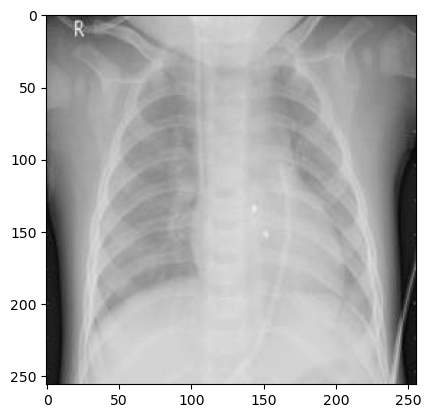

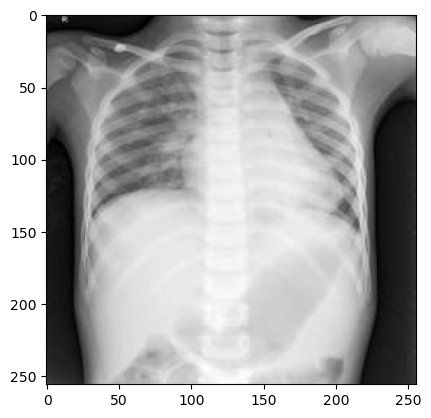

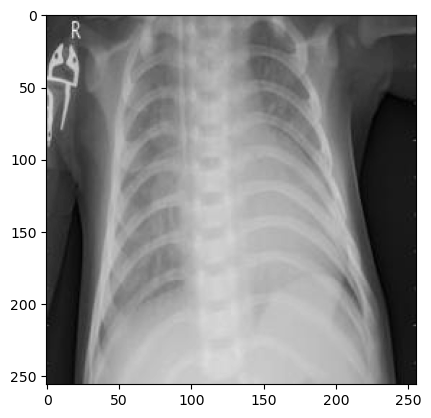

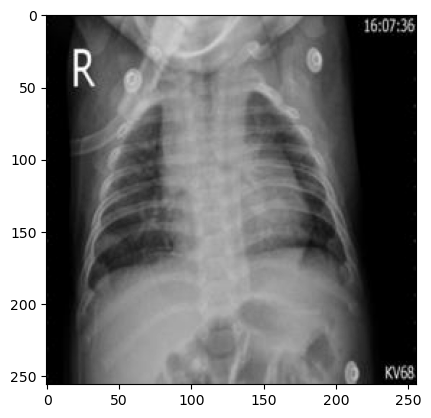

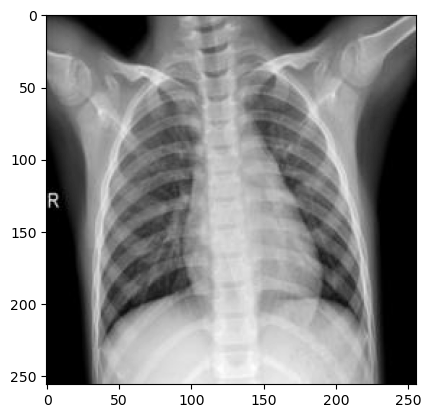

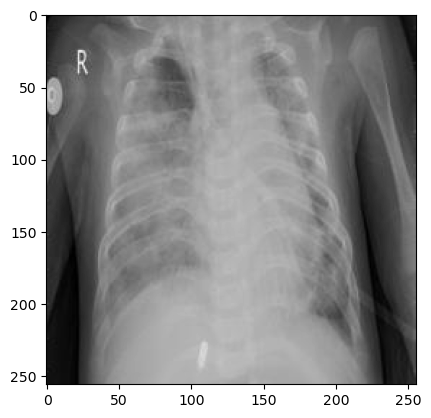

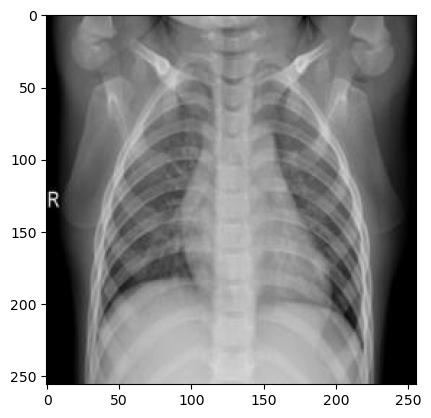

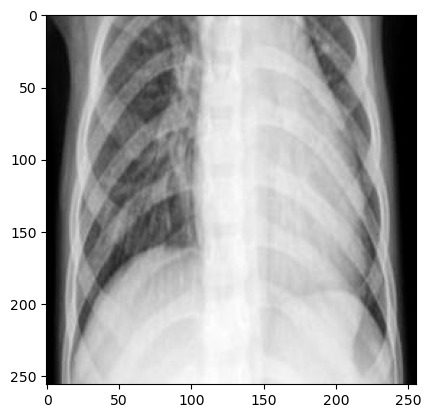

In [109]:
# Get a batch of images from the train dataloader and print it
dataiter = iter(train_dataloader)
image_batch_example = dataiter.next()[0]
for ip in range(batch_size):
    plt.figure()
    plt.imshow(image_batch_example[ip, :].squeeze().detach().numpy(), cmap='gray')
    plt.show()

(256, 256)


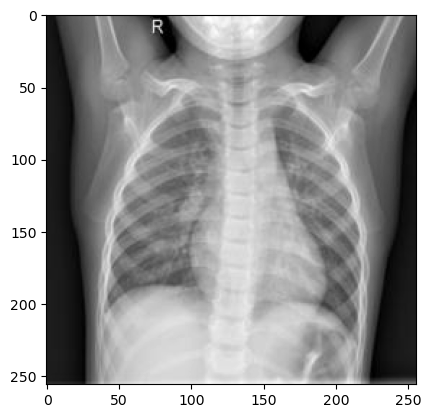

In [110]:
# Load an example image, and normalize it so the values ranges in [0, 1]
image_np = io.imread('Dataset/train_resized_256_256/NORMAL/IM-0115-0001_resized.jpeg')
image_np = image_np / np.max(image_np)

# Since it's a black and white image, all RGB channels are the same, so keep only one
# image_np = image_np[:, :, 0]
print(image_np.shape)

# Display the image
plt.imshow(image_np, cmap='gray')
plt.show()

In [111]:
image_t = torch.tensor(image_np).float()

In [112]:
image_t = image_t.unsqueeze(0).unsqueeze(0)
print(image_t.shape)

torch.Size([1, 1, 256, 256])


In [113]:
cnn_layer1 = nn.Sequential(nn.Conv2d(1, 16, kernel_size=5, padding=2),
                           nn.ReLU(),
                           nn.MaxPool2d(kernel_size=2))
out1 = cnn_layer1(image_batch_example)
print(out1.shape)

torch.Size([8, 16, 128, 128])


In [114]:
cnn_layer2 = nn.Sequential(nn.Conv2d(16, 32, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.MaxPool2d(kernel_size=2))
out2 = cnn_layer2(out1)
print(out2.shape)

torch.Size([8, 32, 64, 64])


In [115]:
new = out2.reshape(out2.size(0),-1)
new.shape

torch.Size([8, 131072])

In [116]:
out3 = out2.reshape(out2.size(0), -1)
lin_layer = nn.Linear(64*64*32, 1)
out3 = lin_layer(out3)
out3

tensor([[0.2558],
        [0.6638],
        [0.2107],
        [0.4514],
        [1.3463],
        [0.7333],
        [0.7232],
        [0.3300]], grad_fn=<AddmmBackward0>)

In [117]:
image_batch_example.shape

torch.Size([8, 1, 256, 256])

In [120]:
class CNN_Classif(nn.Module):
    def __init__(self, num_channels1=16, num_channels2=32, num_classes=2):
        super(CNN_Classif, self).__init__()
        self.cnn_layer1 = nn.Sequential(nn.Conv2d(1, num_channels1, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_channels1),
                        nn.MaxPool2d(kernel_size=2))
        self.cnn_layer2 = nn.Sequential(nn.Conv2d(num_channels1, num_channels2, kernel_size=5, padding=2),
                        nn.ReLU(),
                        nn.BatchNorm2d(num_channels2),
                        nn.MaxPool2d(kernel_size=2))
        self.lin_layer = nn.Linear(64*64*num_channels2, num_classes)
        
    def forward(self, x):
        out = self.cnn_layer1(x)
        out = self.cnn_layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.lin_layer(out)
        return out

In [121]:
def training_cnn_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Set the model
    model = model.to(device)
    model.train()
    
    # define the optimizer (SGD)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to save the training loss over epochs
    loss_total = []
    
    # Training loop
    for epoch in range(num_epochs):
        loss_current_epoch = 0
        for batch_index, (images, labels) in enumerate(train_dataloader):
            # copy images and labels to the device
            images = images.to(device)
            labels = labels.to(device)

            # forward pass
            y_predicted = model(images)
            loss = loss_fn(y_predicted, labels)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Record the loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, save the average loss over batches and display it
        loss_total.append(loss_current_epoch)
        if verbose:
            print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_total

In [122]:
# Eval function

def eval_cnn_classifier(model, eval_dataloader, device):
    # Prepare the model (copy to device and disable some layers (batch norm, dropout...) when evaluating
    model.to(device)
    model.eval() 

    # In test phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct = 0
        total = 0
        for images, labels in eval_dataloader:
            images = images.to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            _, label_predicted = torch.max(y_predicted.data, 1)
            total += labels.size(0)
            correct += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    
    return accuracy

In [123]:
# Instantiate the model
num_channels1 = 16
num_channels2 = 32
num_classes = 2
model_cnn = CNN_Classif(num_channels1, num_channels2, num_classes)

# Print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model_cnn.parameters()))

Total number of parameters:  275490


Epoch [1/20], Loss: 823.0035
Epoch [2/20], Loss: 288.7596
Epoch [3/20], Loss: 196.3694
Epoch [4/20], Loss: 106.6732
Epoch [5/20], Loss: 48.5922
Epoch [6/20], Loss: 38.6626
Epoch [7/20], Loss: 19.4989
Epoch [8/20], Loss: 36.4434
Epoch [9/20], Loss: 6.7017
Epoch [10/20], Loss: 9.6142
Epoch [11/20], Loss: 5.1836
Epoch [12/20], Loss: 5.1674
Epoch [13/20], Loss: 1.8173
Epoch [14/20], Loss: 1.0766
Epoch [15/20], Loss: 0.0091
Epoch [16/20], Loss: 0.0391
Epoch [17/20], Loss: 0.3834
Epoch [18/20], Loss: 0.1804
Epoch [19/20], Loss: 0.1884
Epoch [20/20], Loss: 0.0095


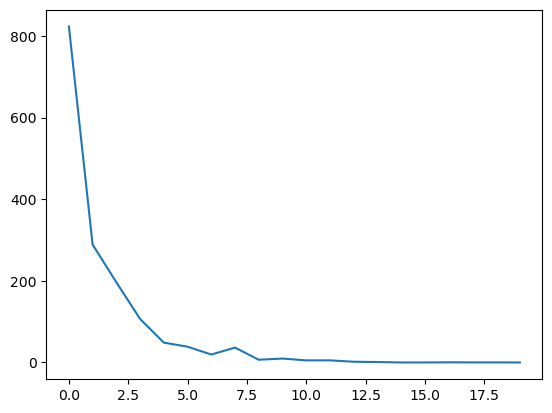

In [124]:
# Optimizer
num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
learning_rate = 0.001

# Training
model_cnn, loss_total = training_cnn_classifier(model_cnn, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True)

# Save the model and display the loss over epochs
torch.save(model_cnn.state_dict(), 'model_cnn_classif.pt')
plt.plot(loss_total)
plt.show()

In [125]:
model_cnn = CNN_Classif(num_channels1, num_channels2, num_classes)
model_cnn.load_state_dict(torch.load('model_cnn_classif.pt'))
accuracy = eval_cnn_classifier(model_cnn, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  72.59615384615384 %


In [ ]:
model.to(device)
model.eval() 